In [ ]:
from paths import (LJLISTS_DIR, LOGS_DIR, 
                  WAVS_DIR, ENCODED_AUDIO_EN_DIR,
                  DATA_DIR, CKPT_DIR,) 
import numpy as np
from utils import normalize_channel, smooth_multivariate_signal
import pandas as pd

version = "v1"
grad_filename = "grad_4750.pt"
version_dir = LOGS_DIR / version

In [104]:
import torch
from model import ArtTTS
from configs import params_v1

from data_phnm import PhnmArticDataset, PhnmArticBatchCollate, PhnmBatchCollate
from torch.utils.data import DataLoader

## Aligned inference draft

In [105]:
data_dir = DATA_DIR
collator = PhnmBatchCollate()

dataset_obj = PhnmArticDataset(
        "resources/filelists/MNGU0/s1_v1.txt",
        #"resources/filelists/ljspeech/valid_v1.txt",
        data_root_dir=DATA_DIR,
        load_coder=False,
        merge_diphtongues=params_v1.merge_diphtongues,
    )

filepaths_list = dataset_obj.filepaths_list

batch_size = 1
batch_filepaths = filepaths_list[ :  batch_size]
phnm3_filepaths = [fp[1] for fp in batch_filepaths]

In [106]:
phnm_embs = [
    {"x": dataset_obj.get_phnm_emb(phnm3_fp)}
    for phnm3_fp in phnm3_filepaths
]

batch = collator(phnm_embs)
x = batch["x"].to(torch.float32)
x_lengths = batch["x_lengths"]

x_durs = [dataset_obj.get_x_durations(phnm3_fp,
                          merge_diphtongues=dataset_obj.merge_diphtongues) for phnm3_fp in phnm3_filepaths]
x_durations = torch.zeros((len(x_durs), x.shape[-1]), dtype=torch.float32)
for i, durs in enumerate(x_durs):
    x_durations[i,:len(durs)] = durs

## PB WITH GETTING EXACTLY THE SAME SIZE AS PHNM EMB... (diphtongues, phnm with various emb lengths...)
for e in x_durs:
    print(e.shape)
print(x_lengths)

torch.Size([54])
tensor([54])


In [107]:
from configs.params_v1 import reorder_feats

device='cpu'

model = ArtTTS(
        params_v1.n_ipa_feats,
        params_v1.n_spks,
        None if params_v1.n_spks == 1 else params_v1.spk_emb_dim,  # spk_emb_dim
        params_v1.n_enc_channels,
        params_v1.filter_channels,
        params_v1.filter_channels_dp,
        params_v1.n_heads,
        params_v1.n_enc_layers,
        params_v1.enc_kernel,
        params_v1.enc_dropout,
        params_v1.window_size,
        params_v1.n_feats,
        params_v1.dec_dim,
        params_v1.beta_min,
        params_v1.beta_max,
        params_v1.pe_scale,
    ).to(device)

ckpt_filepath = CKPT_DIR / version / "grad_4750.pt"
ckpt_state_dict = torch.load(ckpt_filepath, map_location=torch.device(device))

model.load_state_dict(ckpt_state_dict)

y_enc, y_dec, attn = model(
    x, x_lengths, n_timesteps=50, x_durations=x_durations, length_scale=1
)  # (B, 16, T) x 2 , (B,1,T0,T)

y_enc_14 = y_enc[:, reorder_feats, :].detach().cpu()
y_dec_14 = y_dec[:, reorder_feats, :].detach().cpu()

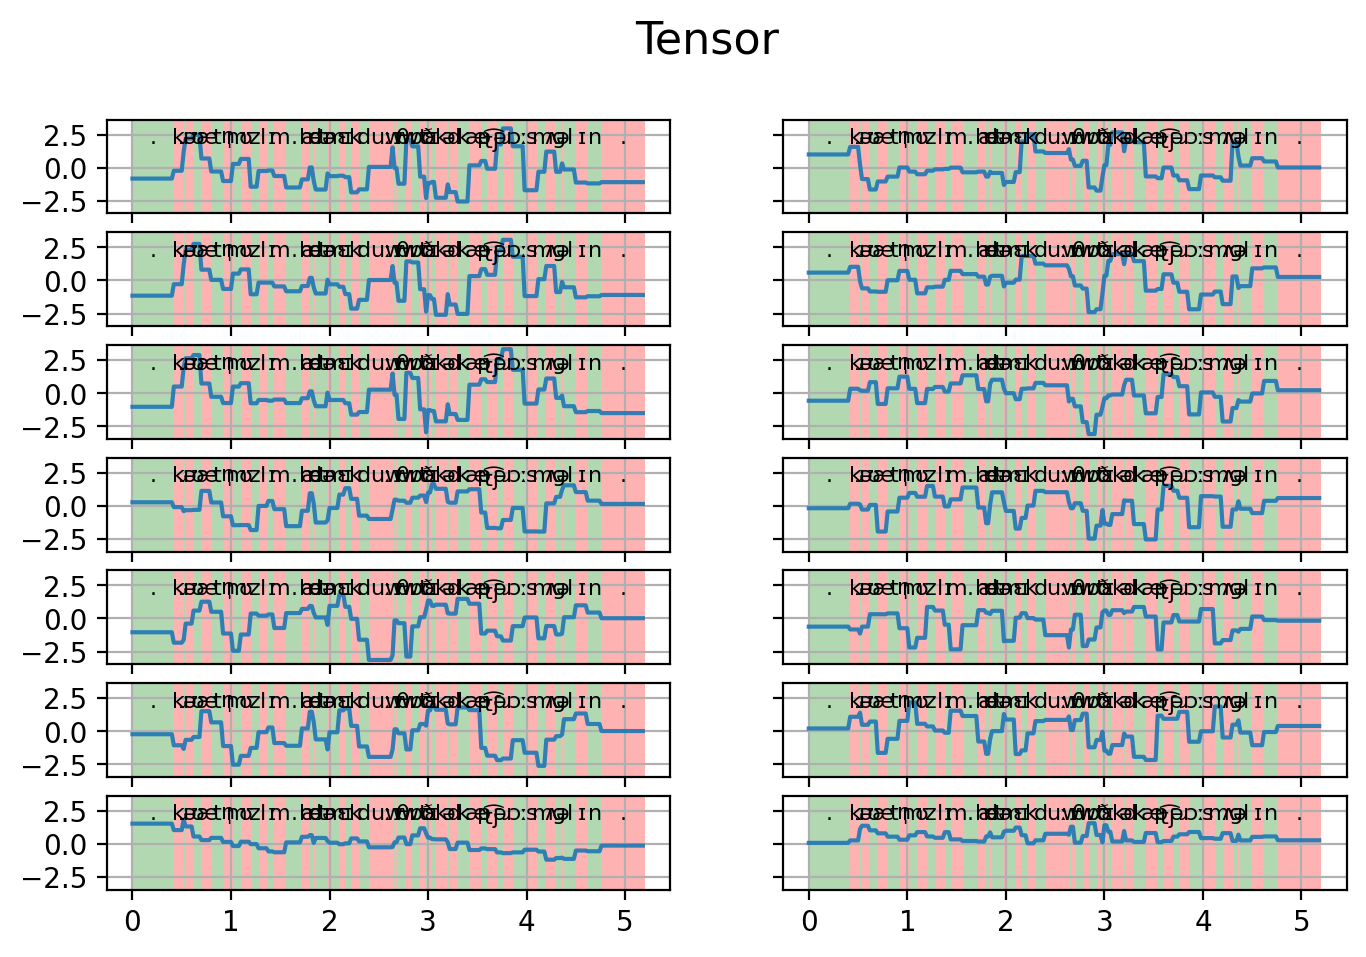

In [109]:
from utils import plot_art_14
from text.phnms import get_pred_phnm3, build_phnm3, get_phnms_from_phnm3

j = 0
phnm3_fp = phnm3_filepaths[j]
phnm3 = np.load(phnm3_fp.replace("DUMMY/", str(DATA_DIR) + "/"))
y_enc_j = y_enc_14[j, :, :]
y_dec_j = y_dec_14[j, :, :]
x_len = x_lengths[j]
attn_j = attn[j, 0, :x_len, :].detach().cpu()  # (x_len, y_len_max)
phnm_map = np.where(attn_j == 1)[0]
y_len = np.max(
    np.where(attn_j[-1])
)
y_enc_j = y_enc_j[:, : y_len + 1].numpy()
y_dec_j = y_dec_j[:, : y_len + 1].numpy()

# label phonemes using model phoneme lengths (using phnm3 disalign due to delta_t to nb frames rounding)

merge_diphtongues = dataset_obj.merge_diphtongues

phnm3_ada = get_pred_phnm3(phnm3, phnm_map, merge_diphtongues=merge_diphtongues)

fig, d = plot_art_14([y_enc_j],
                     #figsize=(6,4),
                     phnm3=phnm3_ada,)
fig

## Test local inference

In [110]:
device='cpu'

model = ArtTTS(
        params_v1.n_ipa_feats,
        params_v1.n_spks,
        None if params_v1.n_spks == 1 else params_v1.spk_emb_dim,  # spk_emb_dim
        params_v1.n_enc_channels,
        params_v1.filter_channels,
        params_v1.filter_channels_dp,
        params_v1.n_heads,
        params_v1.n_enc_layers,
        params_v1.enc_kernel,
        params_v1.enc_dropout,
        params_v1.window_size,
        params_v1.n_feats,
        params_v1.dec_dim,
        params_v1.beta_min,
        params_v1.beta_max,
        params_v1.pe_scale,
    ).to(device)

ckpt_filepath = CKPT_DIR / version / "grad_4750.pt"
ckpt_state_dict = torch.load(ckpt_filepath, map_location=torch.device(device))

model.load_state_dict(ckpt_state_dict)

dataset_obj = PhnmArticDataset(
        "resources/filelists/MNGU0/s1_v1.txt",
        data_root_dir=DATA_DIR,
        load_coder=False,
        merge_diphtongues=params_v1.merge_diphtongues,
    )

reorder_feats = params_v1.reorder_feats
filepaths_list = dataset_obj.filepaths_list
collator = PhnmBatchCollate()

In [112]:
from model import monotonic_align
from model.base import BaseModule
from model.text_encoder import TextEncoder
from model.diffusion import Diffusion
from model.utils import (
    sequence_mask,
    generate_path,
    duration_loss,
    fix_len_compatibility,
)

In [113]:
def relocate_input(x: list):
    """
    Relocates provided tensors to the same device set for the module.
    """
    device = next(model.parameters()).device
    for i in range(len(x)):
        if isinstance(x[i], torch.Tensor) and x[i].device != device:
            x[i] = x[i].to(device)
    return x

encoder = TextEncoder(
            params_v1.n_ipa_feats,
            params_v1.n_feats,
            params_v1.n_enc_channels,
            params_v1.filter_channels,
            params_v1.filter_channels_dp,
            params_v1.n_heads,
            params_v1.n_enc_layers,
            params_v1.enc_kernel,
            params_v1.enc_dropout,
            params_v1.window_size,
        )

decoder = Diffusion(
            params_v1.n_feats,
            params_v1.dec_dim,
            params_v1.n_spks,
            params_v1.spk_emb_dim,
            params_v1.beta_min,
            params_v1.beta_max,
            params_v1.pe_scale
        )

length_scale = 1.0
temperature = 1.0
n_timesteps = 50
stoc=False
spk=None

In [114]:
punc_tok = np.zeros((1, 25))
punc_tok[0, -1] = 1  # set the last dim to 1 for punctuation token
x = torch.tensor(punc_tok.T, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
x_lengths = torch.tensor([1], dtype=torch.long)
y_enc, y_dec, attn = model(x, x_lengths, n_timesteps=50)
sil_enc = y_enc[:,:,0]
sil_enc.shape

torch.Size([1, 16])

In [115]:
#good_sample_id = good_id[0][:-4]
good_sample_id = "mngu0_s1_0001"
np.load(DATA_DIR / "MNGU0" / "arttts" / "s1" / "phnm3" / f"{good_sample_id}_phnm3.npy")

array([(0.   , 0.488, '.'), (0.488, 0.554, 'ɪ'), (0.554, 0.634, 'f'),
       (0.634, 0.676, 'j'), (0.676, 0.708, 'uː'), (0.708, 0.78 , 'w'),
       (0.78 , 0.842, 'ɒ'), (0.842, 0.896, 'n'), (0.896, 0.914, 't'),
       (0.914, 0.974, 't'), (0.974, 1.004, 'uː'), (1.004, 1.104, 'ɹ'),
       (1.104, 1.148, 'ɛ'), (1.148, 1.218, 'ɡ'), (1.218, 1.238, 'j'),
       (1.238, 1.282, 'uː'), (1.282, 1.35 , 'l'), (1.35 , 1.458, 'ɛɪ'),
       (1.458, 1.518, 't'), (1.518, 1.586, 'n'), (1.586, 1.88 , 'ɔɪ'),
       (1.88 , 2.028, 'z'), (2.028, 2.174, '.'), (2.174, 2.23 , 'ɹ'),
       (2.23 , 2.25 , 'ɛ'), (2.25 , 2.324, 'ɡ'), (2.324, 2.356, 'j'),
       (2.356, 2.394, 'uː'), (2.394, 2.462, 'l'), (2.462, 2.58 , 'ɛɪ'),
       (2.58 , 2.62 , 't'), (2.62 , 2.712, 'n'), (2.712, 2.976, 'ɔɪ'),
       (2.976, 3.142, 'z'), (3.142, 3.612, '.')],
      dtype=[('start', '<f4'), ('end', '<f4'), ('phone', '<U10')])

In [117]:
#phnm_embs = [
#                {"x": dataset_obj.get_phnm_emb(f'DUMMY/MNGU0/arttts/s1/phnm3/{id[:-4]}_phnm3.npy',
#                                           #remove_trailing_sil=True,
#                                           )}
#                for id in pb_id[:1]
#            ]
#phnm_embs.append({"x": dataset_obj.get_phnm_emb(f'DUMMY/MNGU0/arttts/s1/phnm3/{max_dur_id}_phnm3.npy')})
good_sample = dataset_obj.get_phnm_emb(f'DUMMY/MNGU0/arttts/s1/phnm3/{good_sample_id}_phnm3.npy')
#bad_sample = dataset_obj.get_phnm_emb(f'DUMMY/MNGU0/arttts/s1/phnm3/{pb_id[1][:-4]}_phnm3.npy')
#good_sample = dataset_obj.get_phnm_emb(f'DUMMY/MNGU0/arttts/s1/phnm3/{max_dur_id}_phnm3.npy')
emb = good_sample
#emb = bad_sample
#emb = torch.cat((good_sample, bad_sample), dim=1)
#emb = torch.cat((emb, emb, emb), dim=1)
phnm_embs = [{"x" : emb} for i in range(2)]
#phnm_embs = [{"x" : good_sample}, {"x" : bad_sample}]
#phnm_embs = [{"x" : good_sample}]
#phnm_embs = [{"x" : bad_sample}]
#phnm_embs = [{"x" : dataset_obj.get_phnm_emb(f'DUMMY/MNGU0/arttts/s1/phnm3/{pb_id[i][:-4]}_phnm3.npy')}
#                for i in range(4)]
batch = collator(phnm_embs)
x = batch["x"].to(torch.float32)
x_lengths = batch["x_lengths"]

In [119]:
model.eval()
with torch.no_grad():
    x, x_lengths = relocate_input([x, x_lengths])

    # Get encoder_outputs `mu_x` and log-scaled token durations `logw`
    mu_x, logw, x_mask = model.encoder(x, x_lengths, spk)

    w = torch.exp(logw) * x_mask
    w_ceil = torch.ceil(w) * length_scale
    y_lengths = torch.clamp_min(torch.sum(w_ceil, [1, 2]), 1).long()
    y_max_length = int(y_lengths.max())
    y_max_length_ = fix_len_compatibility(y_max_length)

    # Using obtained durations `w` construct alignment map `attn`
    y_mask = sequence_mask(y_lengths, y_max_length_).unsqueeze(1).to(x_mask.dtype)
    attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)
    attn = generate_path(w_ceil.squeeze(1), attn_mask.squeeze(1)).unsqueeze(1)

    # Align encoded text and get mu_y
    mu_y = torch.matmul(attn.squeeze(1).transpose(1, 2), mu_x.transpose(1, 2))
    mu_y = mu_y.transpose(1, 2)
    encoder_outputs = mu_y[:, :, :y_max_length]

    print(mu_y.shape)
    print(encoder_outputs.shape)
    print(y_mask.shape)

    #floor_length = 400
    #N = floor_length - mu_y.shape[2]
    #B = mu_y.shape[0]
    #padding = sil_enc.T.repeat(1, N).unsqueeze(0).expand(B, -1, -1)
    #mu_y= torch.cat((padding, mu_y), dim=2)
    #y_mask = torch.cat((torch.ones(B, 1, N, device=mu_y.device), y_mask), dim=2)
    #print(mu_y.shape)
    #print(y_mask.shape)


    # Sample latent representation from terminal distribudecoder_outputs.shapeion N(mu_y, I)
    z = mu_y + torch.randn_like(mu_y, device=mu_y.device) / temperature
    # Generate sample by performing reverse dynamics
    decoder_outputs = model.decoder(z, y_mask, mu_y, n_timesteps, stoc, spk)
    decoder_outputs = decoder_outputs[:, :, :y_max_length]  # Ensure decoder outputs match the expected length                                                                                                                                                                                                                          

torch.Size([2, 16, 200])
torch.Size([2, 16, 200])
torch.Size([2, 1, 200])


## arttts results analysis

In [120]:
dataset = "LJSpeech-1.1"
dataset = "MNGU0"
#dataset = "mocha_timit"
#dataset = "pb2007"
#dataset = "MSPKA_EMA_ita"

if dataset == "MNGU0":
    arttts_folder = "arttts"
    speakers=["s1"]
elif dataset == "mocha_timit":
    arttts_folder = "arttts"
    speakers=["faet0", "ffes0", "fsew0", "maps0", "mjjn0", "msak0"]
elif dataset == "MSPKA_EMA_ita":
    arttts_folder = "arttts"
    speakers=["cnz", "lls", "olm"]
elif dataset == "pb2007":
    arttts_folder = "arttts"
    speakers=["spk1"]
elif dataset == "LJSpeech-1.1":
    arttts_folder = ""
    speakers=[""]

In [121]:
i = 0
speaker = speakers[i]
results_dir = DATA_DIR / dataset / arttts_folder / speaker / "arttts_pred" / version / grad_filename[:-3]
ema_src_dir = DATA_DIR / dataset / arttts_folder / speaker / "encoded_audio_en" / "emasrc"

reslist = sorted(list(results_dir.glob("*.npy")))
print("Files in reslist", len(reslist))

Files in reslist 1354


In [ ]:
fp = reslist[0]
art_res = np.load(fp)
print("art_res.shape", art_res.shape)
y_enc_14 = art_res[:14].T  # (T, 14)
y_dec_14 = art_res[14:28].T  # (T, 14)
print("y_enc_14.shape", y_enc_14.shape, "y_dec_14.shape", y_dec_14.shape)
y_gt_ = np.load(ema_src_dir / fp.name)[:,:14]
y_gt = normalize_channel(y_gt_, channel_idx=12)
print("y_gt.shape", y_gt.shape)

art_res.shape (29, 200)
y_enc_14.shape (200, 14) y_dec_14.shape (200, 14)
y_gt.shape (180, 14)


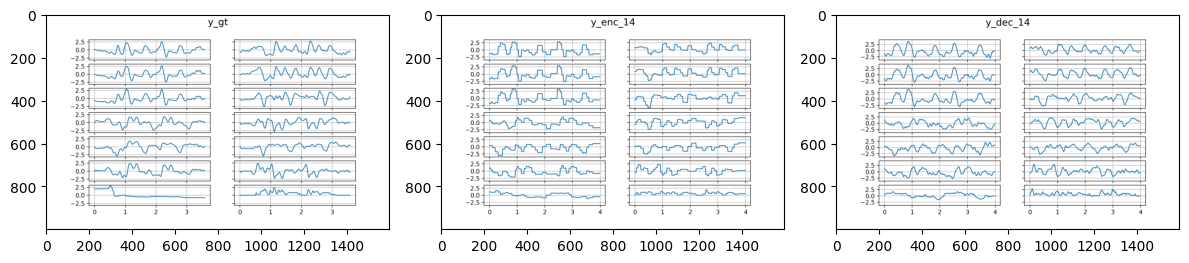

In [125]:
import matplotlib.pyplot as plt
from metrics import signals_from_path, normalized_dtw_score
import numpy as np
from utils import plot_art_14, plot_tensor

fig1, im_data = plot_art_14([y_gt.T], title = "y_gt",)
fig2, im_data = plot_art_14([y_enc_14.T], title = "y_enc_14",)
fig3, im_data = plot_art_14([y_dec_14.T], title = "y_dec_14",)

fig, axes = plt.subplots(1, 3, figsize=(12, 10))

axes[0].imshow(fig1.canvas.renderer.buffer_rgba())
axes[1].imshow(fig2.canvas.renderer.buffer_rgba())
axes[2].imshow(fig3.canvas.renderer.buffer_rgba())

plt.tight_layout()
plt.show()

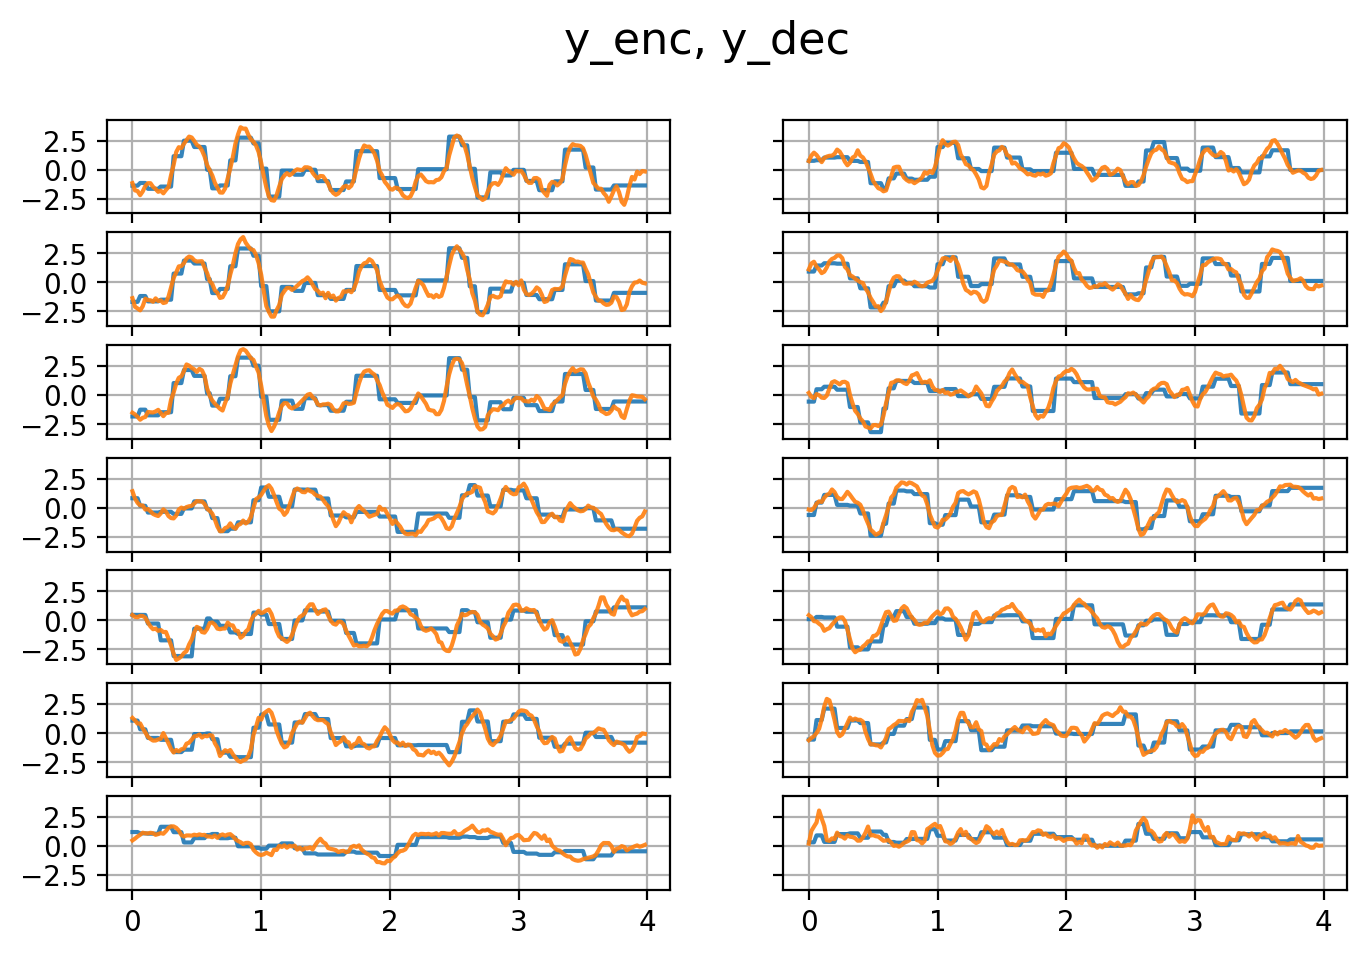

In [126]:
art_feats = np.array([y_enc_14.T, y_dec_14.T])

fig, im_data = plot_art_14(art_feats, title="y_enc, y_dec")
fig

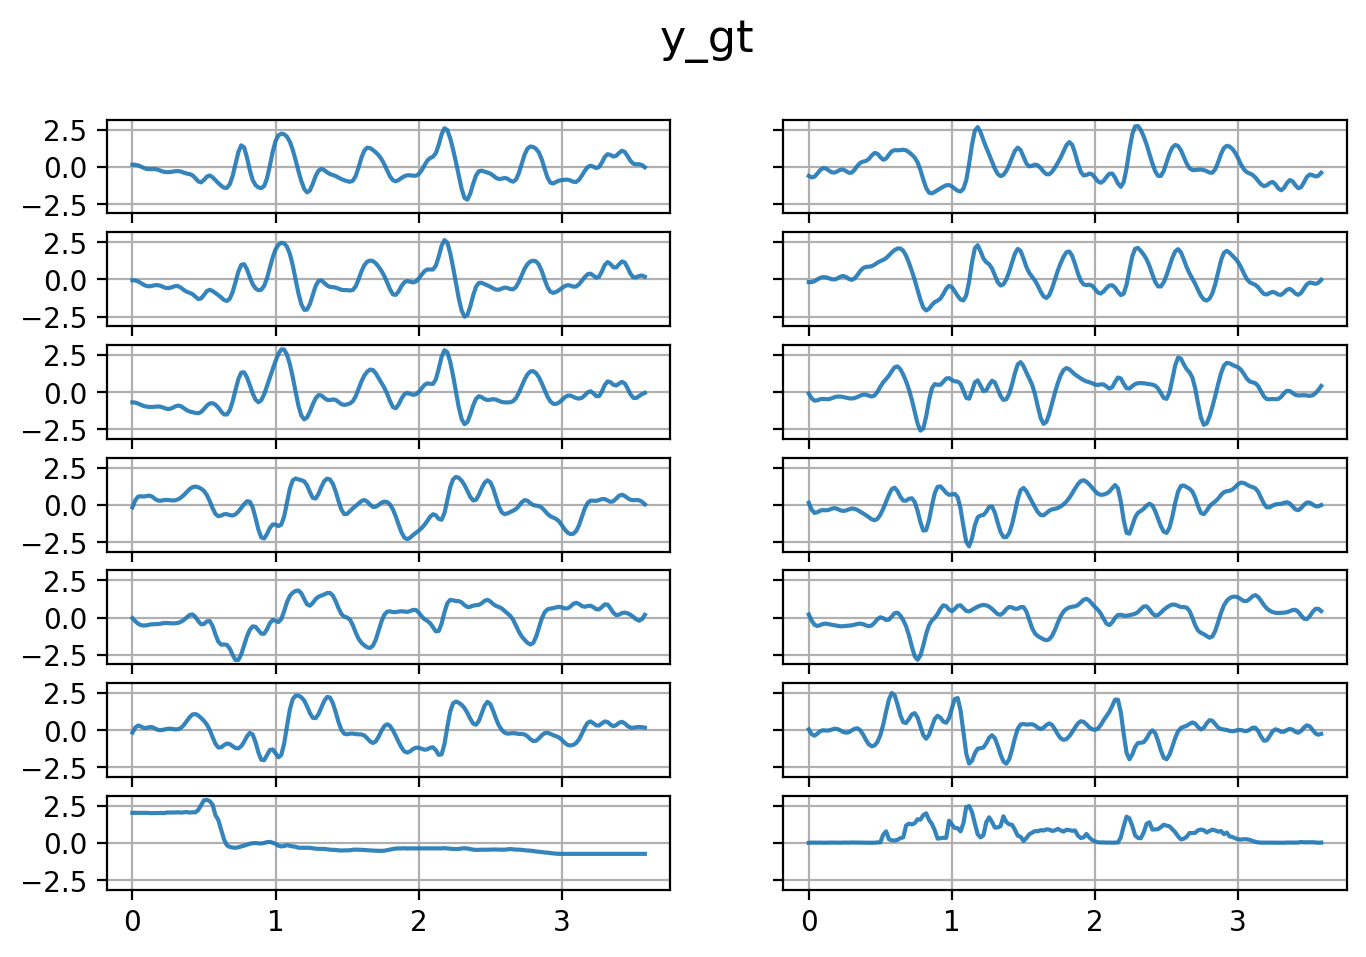

In [127]:
fig, im_data = plot_art_14(np.array([y_gt.T]), title="y_gt")
fig

### DTW on enc and dec articulatory features

In [8]:
dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, y_enc_14)
dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, y_dec_14)

print("dist_gt_enc", dist_gt_enc, "dist_gt_dec", dist_gt_dec)

dist_gt_enc 2.5428851849407734 dist_gt_dec 2.342285892472624


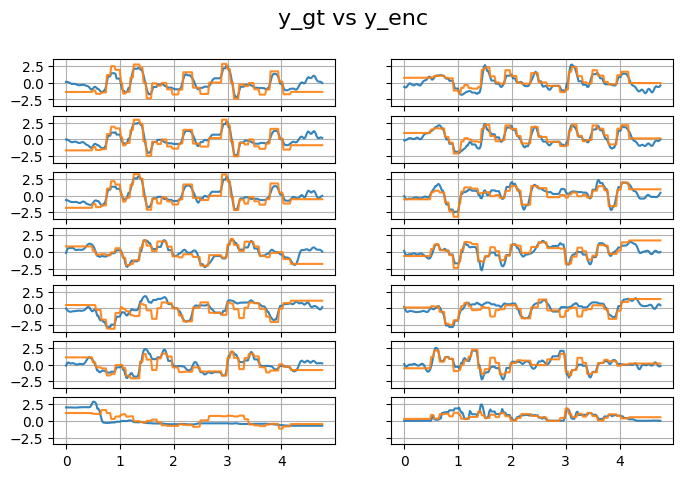

In [9]:
fig, im_data = plot_art_14([y_gt_enc_ada.T,
            y_enc_14_ada.T,],
            title = "y_gt vs y_enc",)
fig

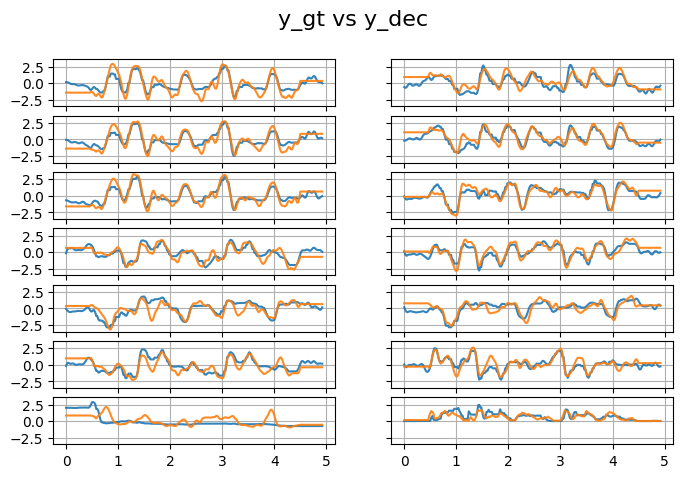

In [10]:
fig, im_data = plot_art_14([y_gt_dec_ada.T,
            y_dec_14_ada.T,],
            title = "y_gt vs y_dec",)
fig

### DTW on smoothened articulatory features

In [11]:
y_dec_14_smoothed = smooth_multivariate_signal(y_dec_14, window_size=3)
dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, y_dec_14_smoothed)
y_enc_14_smoothed = smooth_multivariate_signal(y_enc_14, window_size=3)
dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, y_enc_14_smoothed)

print("dist_gt_enc (smoothed)", dist_gt_enc, "dist_gt_dec (smoothed)", dist_gt_dec)

dist_gt_enc (smoothed) 2.126327365414067 dist_gt_dec (smoothed) 2.2306374591430256


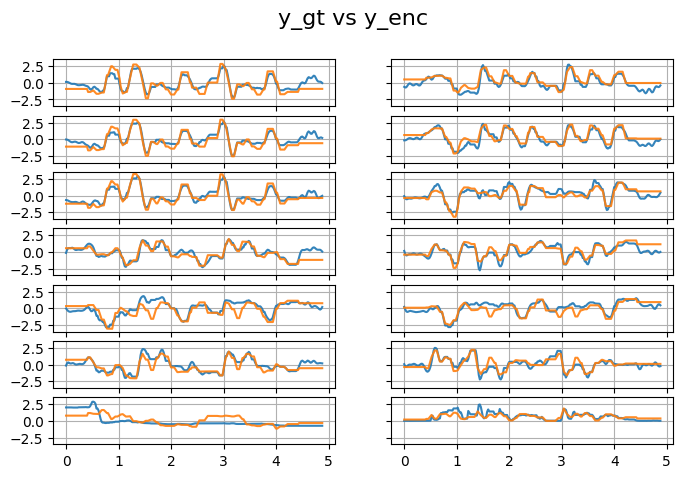

In [12]:
fig, im_data = plot_art_14([y_gt_enc_ada.T,
            y_enc_14_ada.T,],
            title = "y_gt vs y_enc",)
fig

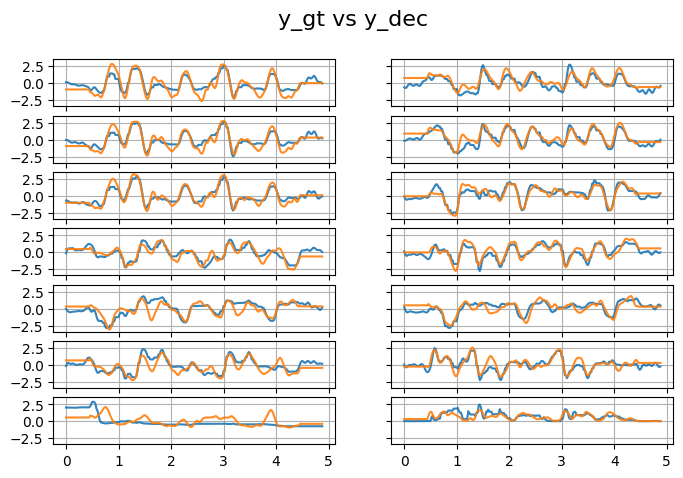

In [13]:
fig, im_data = plot_art_14([y_gt_dec_ada.T,
            y_dec_14_ada.T,],
            title = "y_gt vs y_dec",)
fig

## arttts global analysis

In [147]:
datasets = ["LJSpeech-1.1", "MNGU0", "mocha_timit", "pb2007", "MSPKA_EMA_ita"]

dataset = "LJSpeech-1.1"
dataset = "MNGU0"
dataset = "mocha_timit"
#dataset = "pb2007"
#dataset = "MSPKA_EMA_ita"

if dataset == "MNGU0":
    arttts_folder = "arttts"
    speakers=["s1"]
elif dataset == "mocha_timit":
    arttts_folder = "arttts"
    speakers=["faet0", "ffes0", "fsew0", "maps0", "mjjn0", "msak0"]
elif dataset == "MSPKA_EMA_ita":
    arttts_folder = "arttts"
    speakers=["cnz", "lls", "olm"]
elif dataset == "pb2007":
    arttts_folder = "arttts"
    speakers=["spk1"]
elif dataset == "LJSpeech-1.1":
    arttts_folder = ""
    speakers=[""]

In [ ]:
from scipy.stats import pearsonr
from metrics import normalized_dtw_score
from utils import plot_art_14

prob_enc = []
norm_enc = []
norm_dist_enc = []
norm_dist_dec = []
norm_pcc_enc = []
norm_pcc_dec = []
pb_id = []
good_id = []
good_enc = []
speaker = speakers[0]

results_dir = DATA_DIR / dataset / arttts_folder / speaker / "arttts_pred" / version / "grad_4750" #grad_filename[:-3]
ema_src_dir = DATA_DIR / dataset / arttts_folder / speaker / "encoded_audio_en" / "emasrc"
phnm3_dir = DATA_DIR / dataset / arttts_folder / speaker / "phnm3"

print(len(list(results_dir.glob("*.npy"))), "files in results_dir")
results_list = sorted(list(results_dir.glob("*.npy")))
for idx, fp in enumerate(results_list):
    art_res = np.load(fp)
    enc_14 = art_res[:14]  # (14, T)
    dec_14 = art_res[14:28]  # (14, T)
    y_gt_ = np.load(ema_src_dir / fp.name)[:,:14]
    y_gt = normalize_channel(y_gt_, channel_idx=12)
    #print("enc_14.shape", enc_14.min(), "dec_14.min()", dec_14.min())
    if any(np.isnan(dec_14.flatten())):
        #print("NaN in dec_14", fp.name, i)
        pb_id.append(fp.name)
        prob_enc.append(enc_14)
    else:
        #print("No NaN in dec_14", fp.name, i)
        norm_enc.append(enc_14)
        dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, enc_14.T)
        dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, dec_14.T)
        norm_dist_enc.append(dist_gt_enc)
        norm_dist_dec.append(dist_gt_dec)
        pearson_enc, _ = pearsonr(y_gt_enc_ada, y_enc_14_ada)
        pearson_dec, _ = pearsonr(y_gt_dec_ada, y_dec_14_ada)
        pcc_gt_enc = np.mean(pearson_enc[:12])
        pcc_gt_dec = np.mean(pearson_dec[:12])
        norm_pcc_enc.append(pcc_gt_enc)
        norm_pcc_dec.append(pcc_gt_dec)
        if dec_14.min() > -5 and dec_14.max() < 5:
            good_id.append(fp.name)
            good_enc.append(enc_14)
    #dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, enc_14.T)
    #dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, dec_14.T)
print("NaN in dec_14", len(pb_id))

453 files in results_dir
NaN in dec_14 0


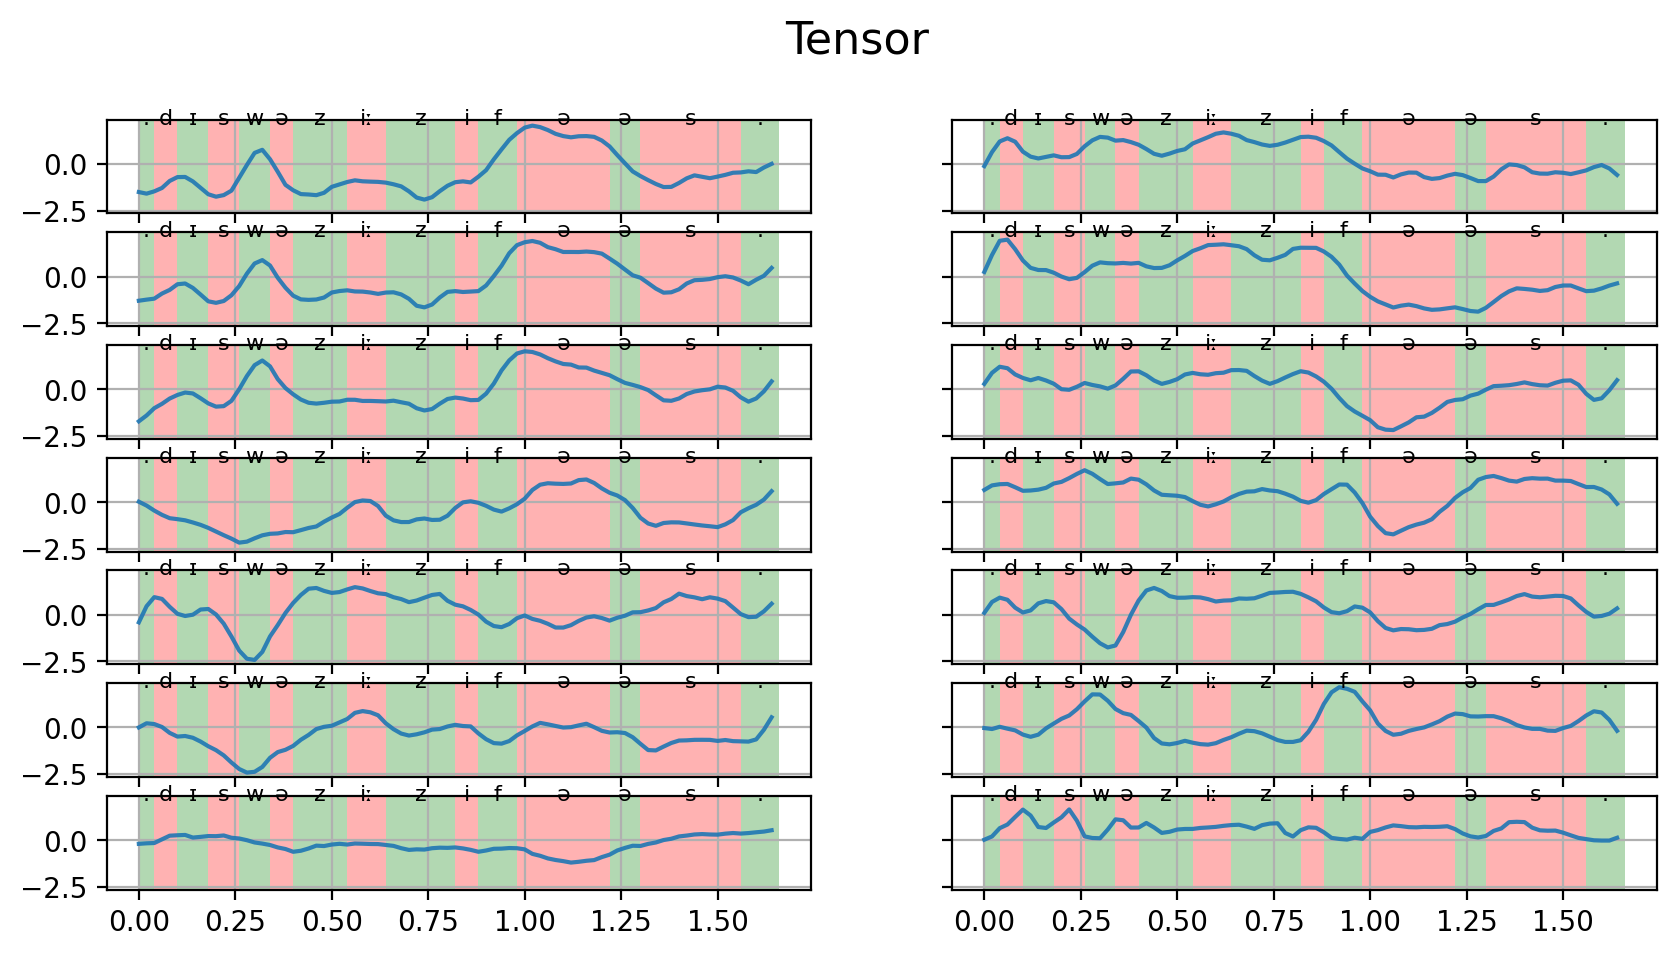

In [150]:
from text.phnms import get_pred_phnm3

art_res = np.load(results_dir / f"{good_id[0][:-4]}.npy")
enc_14 = art_res[:14]  # (14, T)
dec_14 = art_res[14:28]  # (14, T)
phnm3 = get_pred_phnm3(np.load(phnm3_dir / f"{good_id[0][:-4]}_phnm3.npy"),
                        art_res[28],
                        merge_diphtongues=dataset_obj.merge_diphtongues)
fig, ax =plot_art_14([dec_14],
                    figsize=(10, 5),
                    phnm3=phnm3,
                    )
fig

In [155]:
norm_max = [e.max() for e in norm_enc]
norm_min = [e.min() for e in norm_enc]
norm_len = [e.shape[1] / 50 for e in norm_enc]

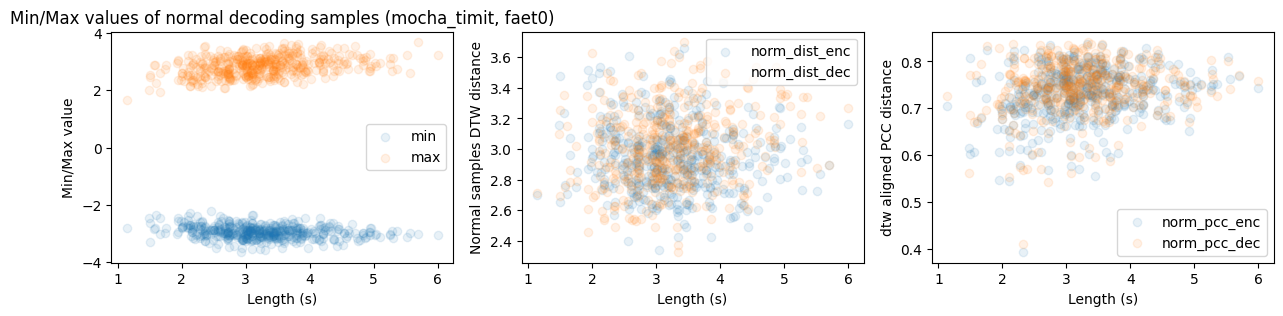

In [156]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(15, 3))

ax[0].scatter(norm_len, norm_min, alpha= 0.1)
ax[0].scatter(norm_len, norm_max, alpha= 0.1)
ax[0].set_xlabel("Length (s)")
ax[0].set_ylabel("Min/Max value")
ax[0].set_title(f"Min/Max values of normal decoding samples ({dataset}, {speaker})")
ax[0].legend(["min", "max"])

ax[1].scatter(norm_len, norm_dist_enc, alpha=0.1, label="norm_dist_enc")
ax[1].scatter(norm_len, norm_dist_dec, alpha=0.1, label="norm_dist_dec")
ax[1].set_xlabel("Length (s)")
ax[1].set_ylabel("Normal samples DTW distance")
ax[1].legend()

ax[2].scatter(norm_len, norm_pcc_enc, alpha=0.1, label="norm_pcc_enc")
ax[2].scatter(norm_len, norm_pcc_dec, alpha=0.1, label="norm_pcc_dec")
ax[2].set_xlabel("Length (s)")
ax[2].set_ylabel("dtw aligned PCC distance")

ax[2].legend()

plt.show()

In [ ]:
from scipy.stats import pearsonr

version = "v1"
epoch = 4750  # 210, 370, 565, 4750

results_summary = []

for epoch in [4750]:#, 565, 4750]:
#for epoch in ['4750']:#, 565, 4750]:
    grad_filename = f"grad_{epoch}.pt"  # 210, 370, 565
    for speaker in speakers:
        results_dir = DATA_DIR / dataset / arttts_folder / speaker / "arttts_pred" / version / grad_filename[:-3]
        ema_src_dir = DATA_DIR / dataset / arttts_folder / speaker / "encoded_audio_en" / "emasrc"

        reslist = sorted(list(results_dir.glob("*.npy")))
        print("version", version , "ckpt", grad_filename, "speaker:", speaker, "Files in reslist", len(reslist))
        #reslist = valid_samples
        #print("version", version , "ckpt", grad_filename, "speaker:", speaker, "valid_samples", len(reslist))
        rel_len_diffs = []
        dist_gt_encs = []
        dist_gt_decs = []
        pcc_gt_encs = []
        pcc_gt_decs = []

        for i, fp in enumerate(reslist):
            art_res = np.load(results_dir / fp.name)
            y_enc_14 = art_res[:14].T  # (T, 14)
            y_dec_14 = art_res[14:28].T  # (T, 14)
            y_gt_ = np.load(ema_src_dir / fp.name)[:,:14]
            y_gt = normalize_channel(y_gt_, channel_idx=12)
            rel_len_diffs.append((y_enc_14.shape[0] / y_gt.shape[0] - 1 )*100)
            try:
                dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, y_enc_14)
                dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, y_dec_14)
                pearson_enc, _ = pearsonr(y_gt_enc_ada, y_enc_14_ada)
                pearson_dec, _ = pearsonr(y_gt_dec_ada, y_dec_14_ada)
                pcc_gt_enc = np.mean(pearson_enc[:12])
                pcc_gt_dec = np.mean(pearson_dec[:12])
                pcc_gt_encs.append(pcc_gt_enc)
                pcc_gt_decs.append(pcc_gt_dec)
                dist_gt_encs.append(dist_gt_enc)
                dist_gt_decs.append(dist_gt_dec)
            except Exception as e:
                print(f"Error processing {fp.name}: {e}")
                print(y_gt.max(), y_enc_14.max(), y_dec_14.min())
        row = {
            "version": version,
            "epoch": epoch,
            "speaker": speaker,
            "mean_rel_len_diff": np.mean(rel_len_diffs),
            "std_rel_len_diff": np.std(rel_len_diffs),
            "mean_dist_gt_enc": np.mean(dist_gt_encs),
            "std_dist_gt_enc": np.std(dist_gt_encs),
            "mean_dist_gt_dec": np.mean(dist_gt_decs),
            "std_dist_gt_dec": np.std(dist_gt_decs),
            "mean_pcc_gt_enc": np.mean(pcc_gt_encs),
            "std_pcc_gt_enc": np.std(pcc_gt_encs),
            "mean_pcc_gt_dec": np.mean(pcc_gt_decs),
            "std_pcc_gt_dec": np.std(pcc_gt_decs),
        }
        results_summary.append(row)
        #print(f"dist_gt_enc: {np.mean(dist_gt_encs):.4f}, std {np.std(dist_gt_encs):.4f}, min {np.min(dist_gt_encs):.4f}, max {np.max(dist_gt_encs):.4f}")
        #print(f"dist_gt_dec: {np.mean(dist_gt_decs):.4f}, std {np.std(dist_gt_decs):.4f}, min {np.min(dist_gt_decs):.4f}, max {np.max(dist_gt_decs):.4f}")
        #print(f"pcc_gt_enc: {np.mean(pcc_gt_encs):.4f}, std {np.std(pcc_gt_encs):.4f}, min {np.min(pcc_gt_encs):.4f}, max {np.max(pcc_gt_encs):.4f}")
        #print(f"pcc_gt_dec: {np.mean(pcc_gt_decs):.4f}, std {np.std(pcc_gt_decs):.4f}, min {np.min(pcc_gt_decs):.4f}, max {np.max(pcc_gt_decs):.4f}")

results_df = pd.DataFrame(results_summary)
results_df

version v1 ckpt grad_4750.pt speaker: faet0 Files in reslist 453


version v1 ckpt grad_4750.pt speaker: ffes0 Files in reslist 458
version v1 ckpt grad_4750.pt speaker: fsew0 Files in reslist 455
version v1 ckpt grad_4750.pt speaker: maps0 Files in reslist 454
version v1 ckpt grad_4750.pt speaker: mjjn0 Files in reslist 459
version v1 ckpt grad_4750.pt speaker: msak0 Files in reslist 459


version  epoch speaker  mean_rel_len_diff  std_rel_len_diff  \
0      v1   4750   faet0         -18.220493         11.271263   
1      v1   4750   ffes0         -20.461277         10.640956   
2      v1   4750   fsew0         -18.882349         10.746404   
3      v1   4750   maps0         -14.385448         14.417594   
4      v1   4750   mjjn0         -26.738110         10.088998   
5      v1   4750   msak0         -18.660812         11.080522   

   mean_dist_gt_enc  std_dist_gt_enc  mean_dist_gt_dec  std_dist_gt_dec  \
0          2.944571         0.222548          3.010932         0.243299   
1          3.131039         0.257590          3.204238         0.287832   
2          2.716487         0.227375          2.758840         0.293625   
3          2.866740         0.228347          2.968426         0.283548   
4          2.944313         0.222891          2.985015         0.268303   
5          2.893260         0.223365          2.973877         0.267609   

   mean_pcc_gt_enc  std_pcc_gt_enc  mean_pcc_gt_dec  std_pcc_gt_dec  
0         0.730672        0.055851         0.743911        0.054988  
1         0.675344        0.063749         0.693418        0.061349  
2         0.762687        0.049460         0.781436        0.049759  
3         0.706099        0.061327         0.716213        0.062393  
4         0.719658        0.061380         0.736845        0.062453  
5         0.730522        0.056450         0.743241        0.055070

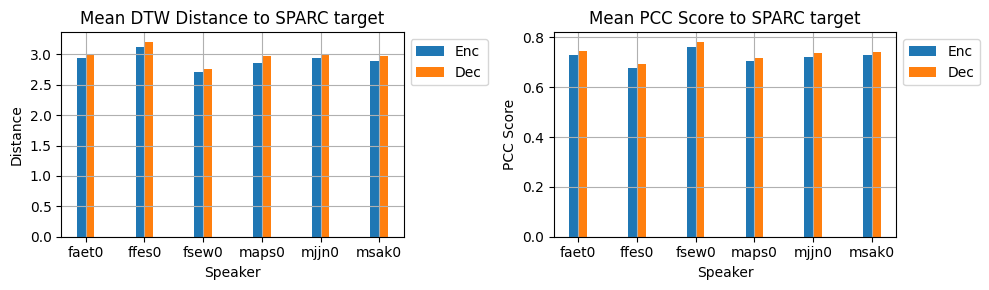

In [169]:
short_df = results_df[results_df["epoch"] == 4750]

if len(short_df) == 1:
    # Calculate mean and standard deviation for enc, dec, and sparc
    means = [
        short_df["mean_dist_gt_enc"],
        short_df["mean_dist_gt_dec"],
    ]
    stds = [
        short_df["std_dist_gt_enc"],
        short_df["std_dist_gt_dec"],
    ]

    # Labels for the bars
    labels = ["Enc", "Dec",]

    # Plot the bar chart
    fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharey=False, sharex=True)
    #plot stds
    ax[0].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='s1', color='orange')
    ax[0].set_ylabel("DTW")
    ax[0].grid(axis='y')
    #ax[0].legend()

    means = [
        short_df["mean_pcc_gt_enc"],
        short_df["mean_pcc_gt_dec"],
    ]
    stds = [
        short_df["std_pcc_gt_enc"],
        short_df["std_pcc_gt_dec"],
    ]


    ax[1].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='s1', color='green')

    ax[1].set_ylabel("PCC")
    ax[1].grid(axis='y')
    #ax[1].legend()

    plt.suptitle(f"{dataset} Mean and std of DTW/PCC score for Enc, Dec compared to SPARC")
    plt.tight_layout()
    plt.show()

else:
    # Example data
    speakers = short_df["speaker"]
    mean_dist_gt_enc = short_df["mean_dist_gt_enc"]
    mean_dist_gt_dec = short_df["mean_dist_gt_dec"]
    mean_pcc_gt_enc = short_df["mean_pcc_gt_enc"]
    mean_pcc_gt_dec = short_df["mean_pcc_gt_dec"]

    x = np.arange(len(speakers))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))

    # First subplot
    ax[0].bar(x - width/2, mean_dist_gt_enc, width, label="Enc")
    ax[0].bar(x + width/2, mean_dist_gt_dec, width, label="Dec")
    ax[0].set_title("Mean DTW Distance to SPARC target")
    ax[0].set_xlabel("Speaker")
    ax[0].set_ylabel("Distance")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(speakers)
    ax[0].grid()
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Second subplot
    ax[1].bar(x - width/2, mean_pcc_gt_enc, width, label="Enc")
    ax[1].bar(x + width/2, mean_pcc_gt_dec, width, label="Dec")
    ax[1].set_title("Mean PCC Score to SPARC target")
    ax[1].set_xlabel("Speaker")
    ax[1].set_ylabel("PCC Score")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(speakers)
    ax[1].grid()
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


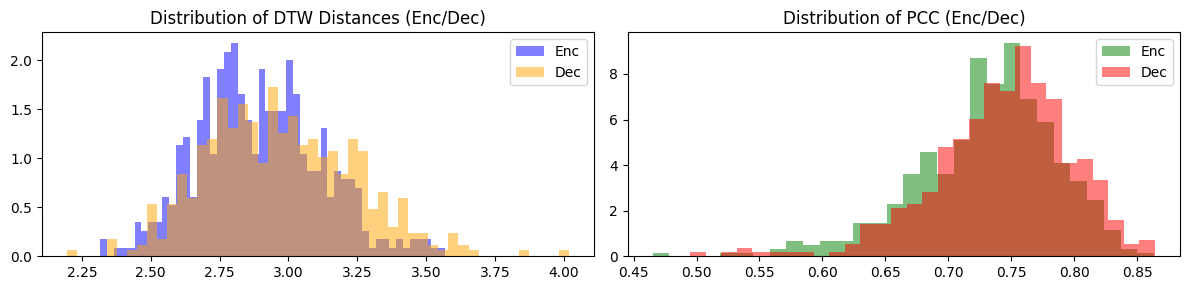

In [170]:
fig, ax = plt.subplots(1, 2 , figsize=(12, 3))

ax[0].set_title('Distribution of DTW Distances (Enc/Dec)')
ax[0].hist(dist_gt_encs, bins=50, density=True, color='blue', alpha=0.5, label='Enc')
#clamp values to 5 for better visualization
ax[0].hist([min(x, 5) for x in dist_gt_decs], bins=50, density=True, color='orange', alpha=0.5, label='Dec')
ax[0].legend()

ax[1].set_title('Distribution of PCC (Enc/Dec)')
ax[1].hist(pcc_gt_encs, bins=30, density=True, color='green', alpha=0.5, label='Enc')
ax[1].hist(pcc_gt_decs, bins=30, density=True, color='red', alpha=0.5, label='Dec')
ax[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
worst_idx = np.argmin(pcc_gt_decs)
print("Worst index:", worst_idx, "score", pcc_gt_decs[worst_idx])
worst_fp = reslist[worst_idx]
print("Worst file:", worst_fp.name)

best_idx = np.argmax(pcc_gt_decs)
print("Best index:", best_idx, "score", pcc_gt_decs[best_idx])
best_fp = reslist[best_idx]
print("Best file:", best_fp.name)


art_res = np.load(worst_fp)
art_res = np.load(best_fp)
y_enc_14 = art_res[:14].T  # (T, 14)
y_dec_14 = art_res[14:28].T  # (T, 14)
y_gt_ = np.load(ema_src_dir / fp.name)[:,:14]
y_gt = normalize_channel(y_gt_, channel_idx=12)
rel_len_diffs.append((y_dec_14.shape[0] / y_gt.shape[0] - 1 )*100)
try:
    dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, y_enc_14)
    dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, y_dec_14)
except Exception as e:
    print(f"Error processing {fp.name}: {e}")
    dist_gt_enc, dist_gt_dec = np.nan, np.nan

Worst index: 452 score 0.49484390902716635
Worst file: msak0_454.npy
Best index: 364 score 0.8641104456535778
Best file: msak0_365.npy


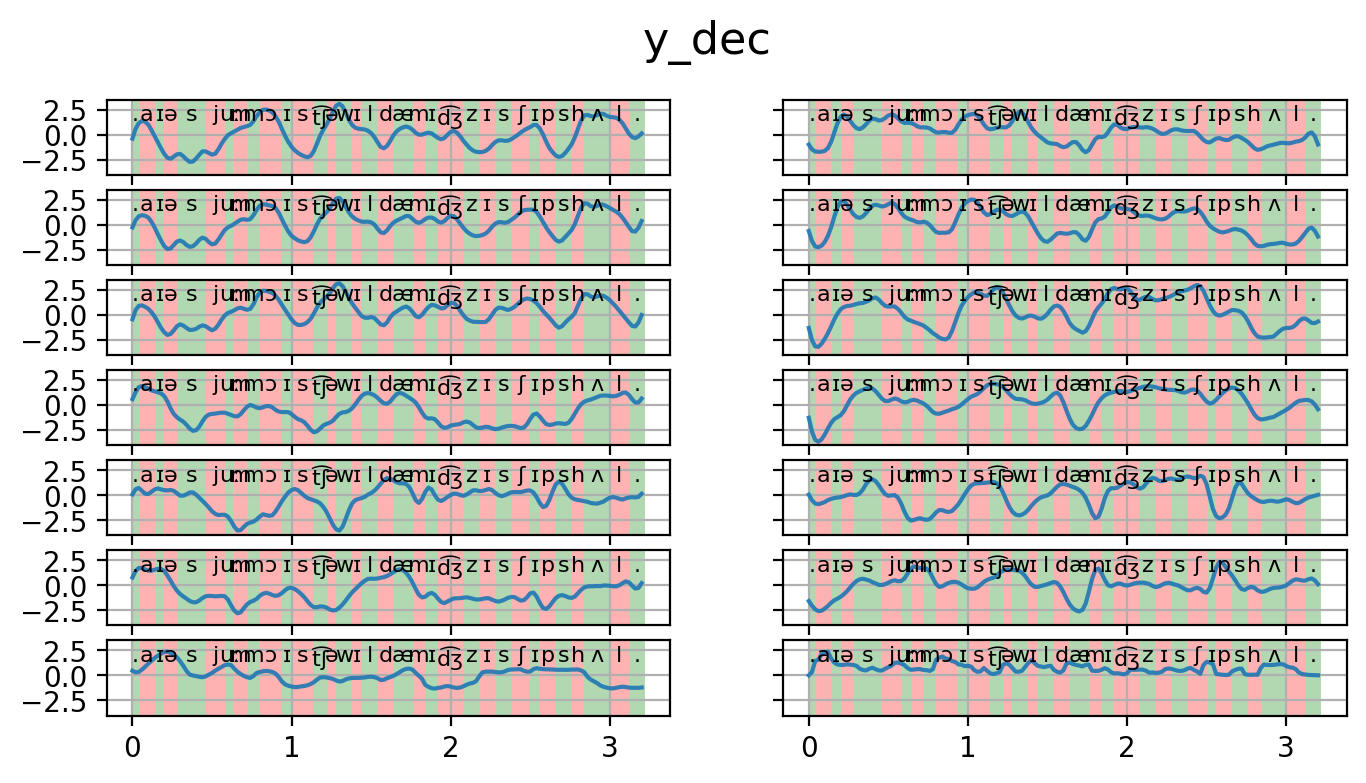

In [179]:
fig, im_data = plot_art_14(np.array([y_dec_14.T]),
                           title="y_dec",
                           figsize=(8, 4),
                           phnm3=get_pred_phnm3(np.load(DATA_DIR / dataset / arttts_folder / speaker / "phnm3" / f"{best_fp.name[:-4]}_phnm3.npy"),
                                                art_res[28],
                                                merge_diphtongues=False),
                           )
fig

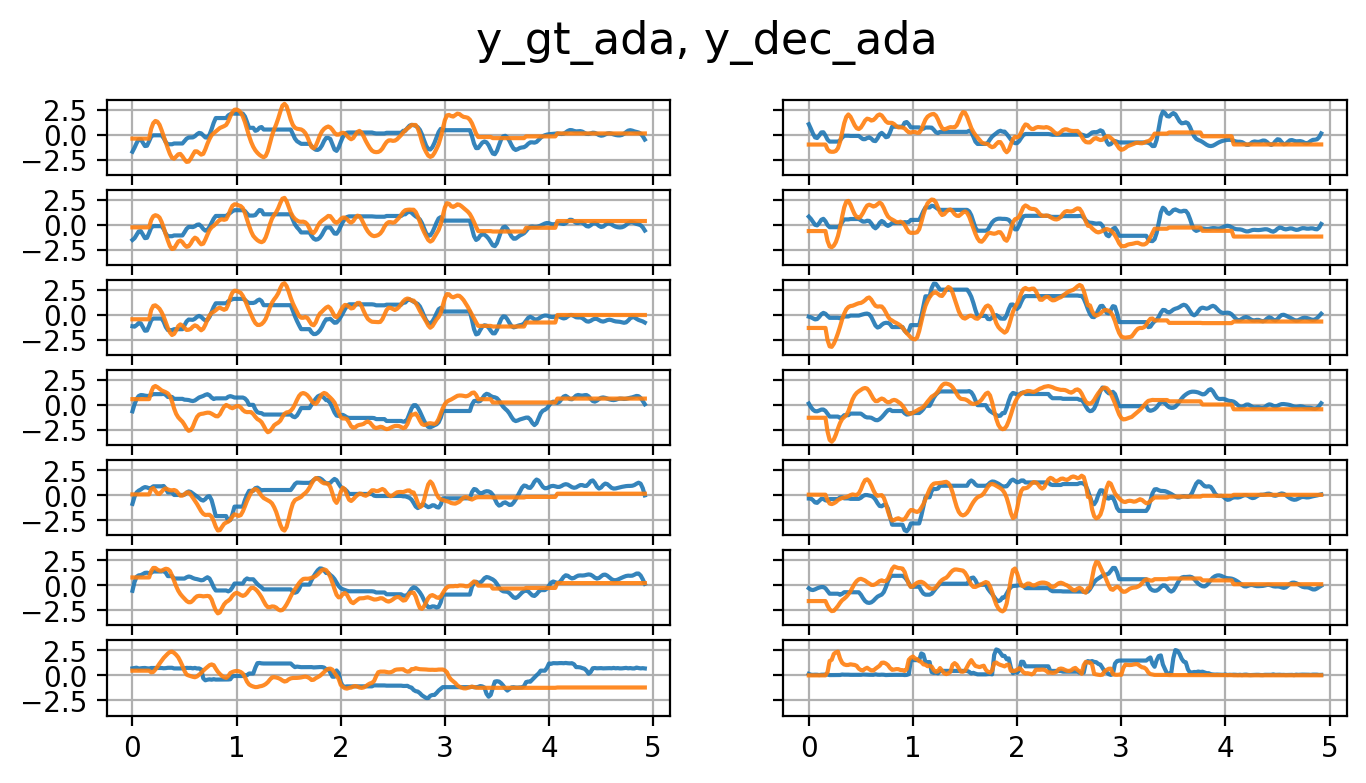

In [181]:
fig, im_data = plot_art_14(np.array([y_gt_dec_ada.T,
                                     y_dec_14_ada.T]),
                           title="y_gt_ada, y_dec_ada",
                           figsize=(8, 4),
                           )
fig

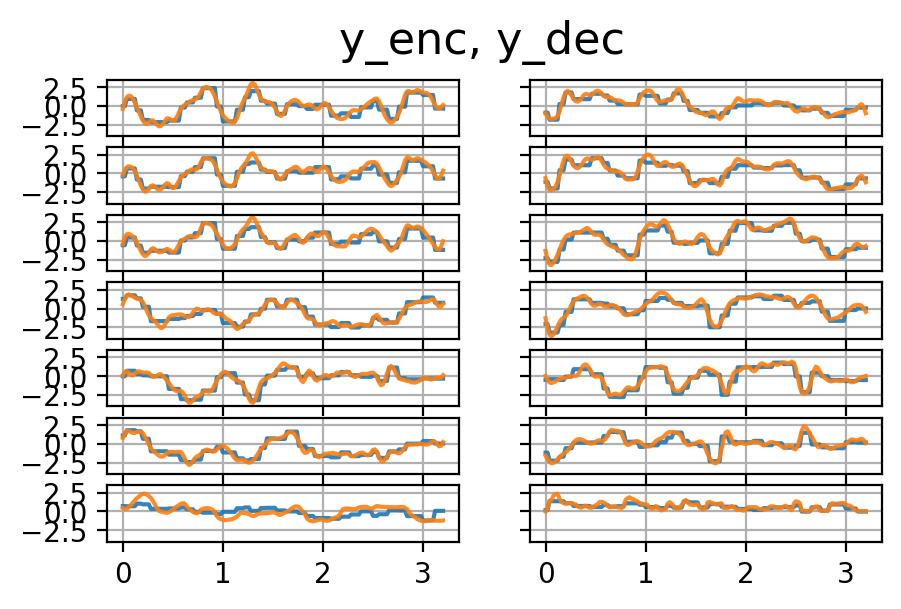

In [185]:
art_feats = np.array([y_enc_14.T, y_dec_14.T])

fig, im_data = plot_art_14(art_feats, title="y_enc, y_dec",
                           figsize=(5, 3),)
fig

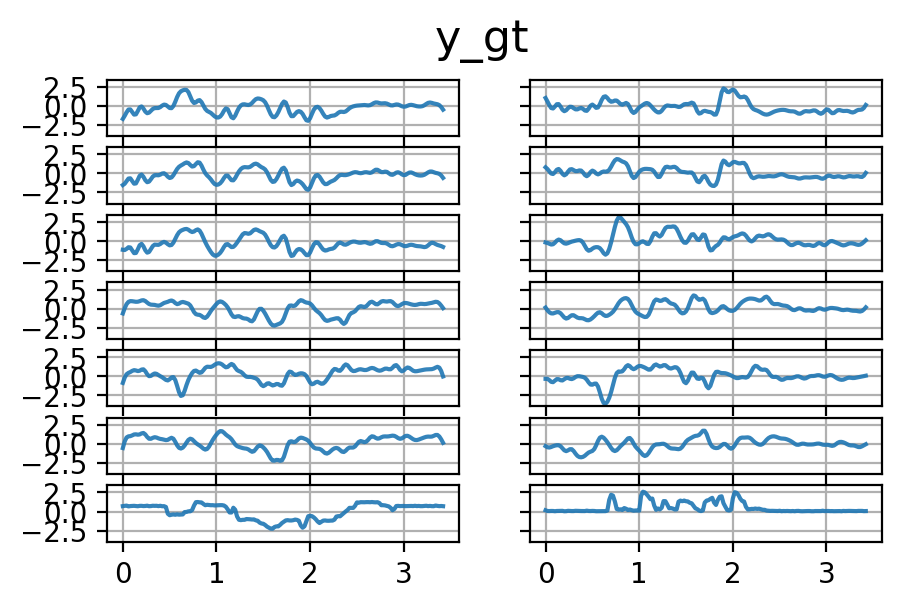

In [186]:
fig, im_data = plot_art_14(np.array([y_gt.T]), title="y_gt",
                           figsize=(5, 3),)
fig

### DTW on enc and dec articulatory features

In [39]:
dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, y_enc_14)
dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, y_dec_14)

print("dist_gt_enc", dist_gt_enc, "dist_gt_dec", dist_gt_dec)

dist_gt_enc 4.082213215977802 dist_gt_dec 3.985734668161091


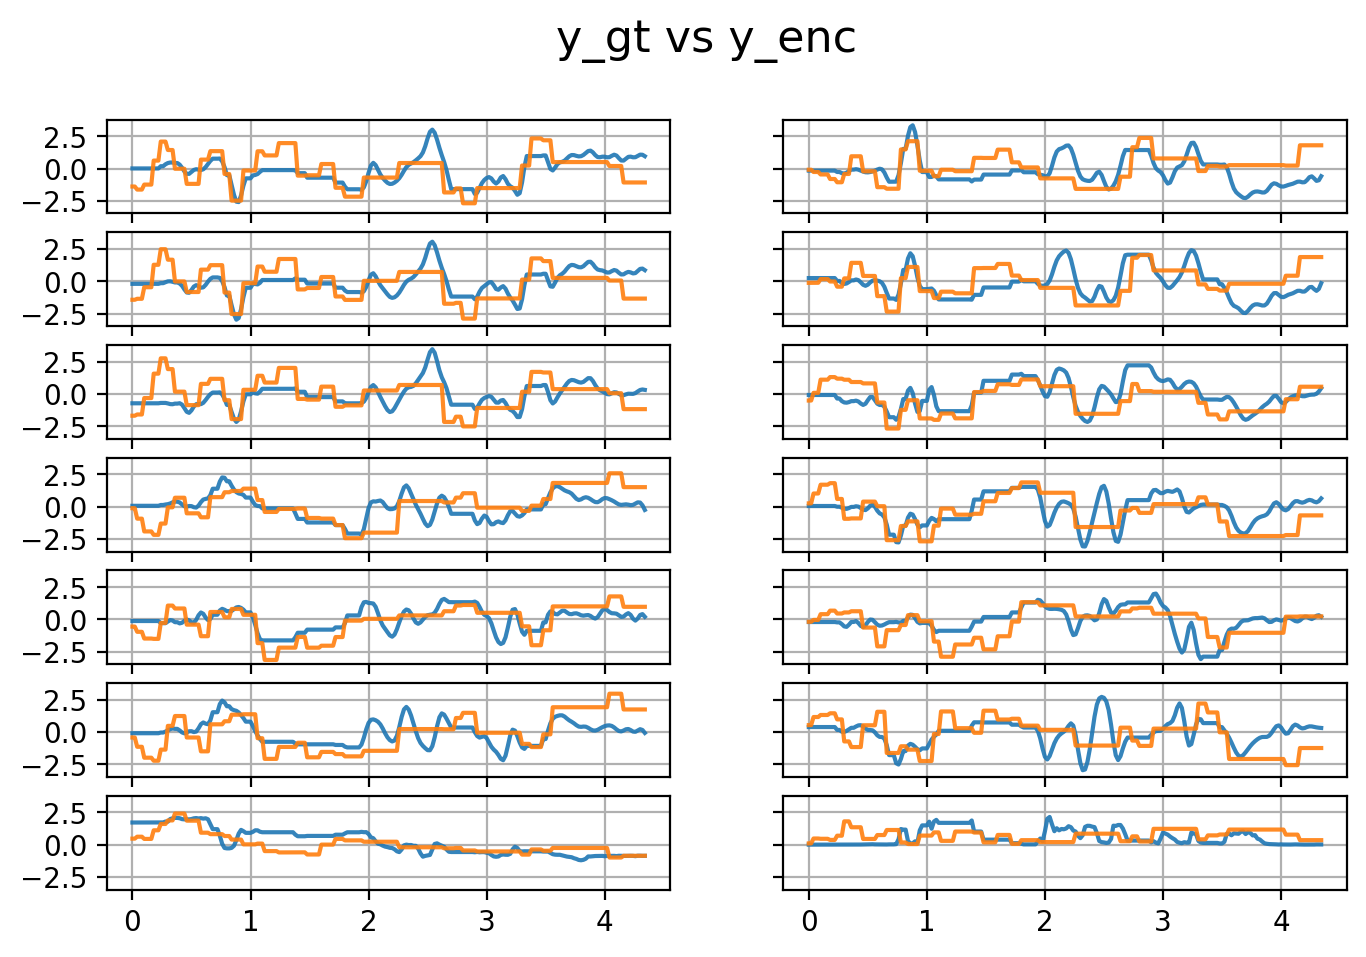

In [40]:
fig, im_data = plot_art_14([y_gt_enc_ada.T,
            y_enc_14_ada.T,],
            title = "y_gt vs y_enc",)
fig

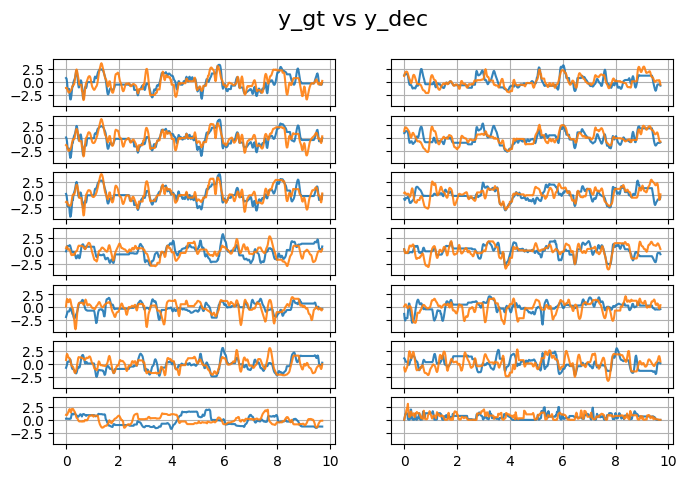

In [27]:
fig, im_data = plot_art_14([y_gt_dec_ada.T,
            y_dec_14_ada.T,],
            title = "y_gt vs y_dec",)
fig

### DTW on smoothened articulatory features

In [28]:
y_dec_14_smoothed = smooth_multivariate_signal(y_dec_14, window_size=3)
dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(y_gt, y_dec_14_smoothed)
y_enc_14_smoothed = smooth_multivariate_signal(y_enc_14, window_size=3)
dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(y_gt, y_enc_14_smoothed)

print("dist_gt_enc (smoothed)", dist_gt_enc, "dist_gt_dec (smoothed)", dist_gt_dec)

dist_gt_enc (smoothed) 3.923766176820091 dist_gt_dec (smoothed) 4.2319792020062925


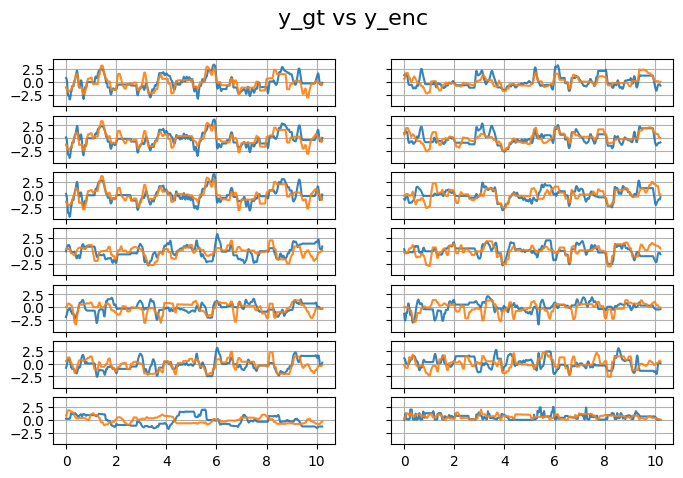

In [29]:
fig, im_data = plot_art_14([y_gt_enc_ada.T,
            y_enc_14_ada.T,],
            title = "y_gt vs y_enc",)
fig

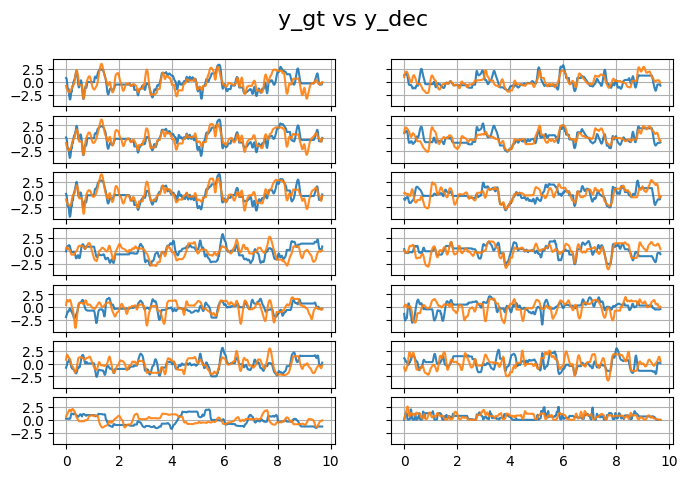

In [30]:
fig, im_data = plot_art_14([y_gt_dec_ada.T,
            y_dec_14_ada.T,],
            title = "y_gt vs y_dec",)
fig

## Explore data distribs (train and problematic cases)

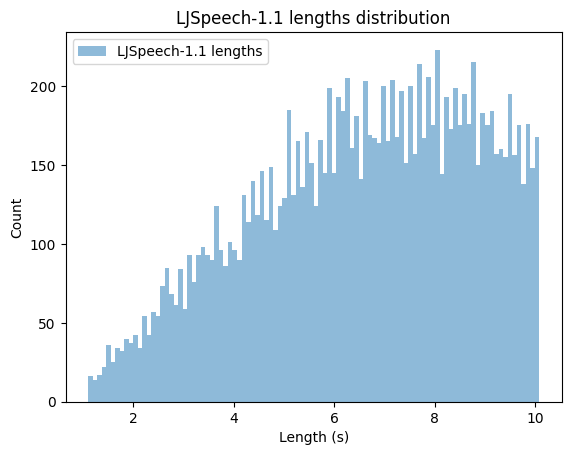

In [187]:
import matplotlib.pyplot as plt

ljdir = DATA_DIR / "LJSpeech-1.1" / "encoded_audio_en" / "emasrc"

lj_lengths = []
for i, e in enumerate(ljdir.glob("*.npy")):
    art = np.load(e)
    lj_lengths.append(art.shape[0] / 50)
plt.hist(lj_lengths, bins=100, alpha=0.5, label="LJSpeech-1.1 lengths")
plt.title("LJSpeech-1.1 lengths distribution")
plt.xlabel("Length (s)")
plt.ylabel("Count")
plt.legend()
plt.show();

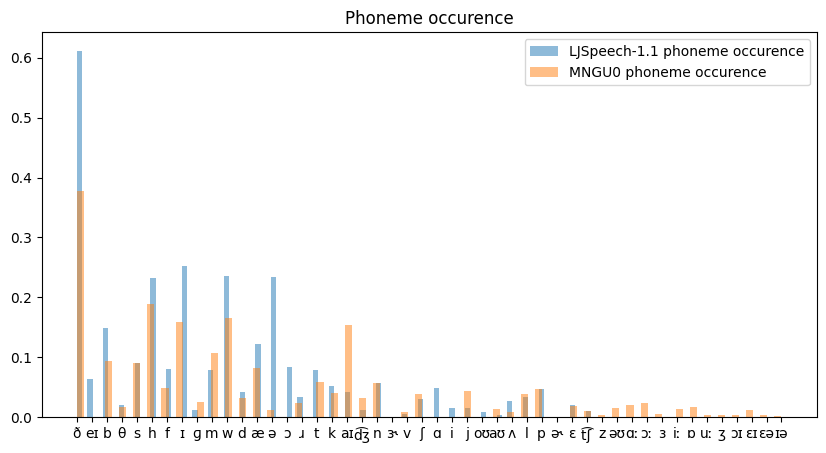

In [188]:
ljphnm3dir = DATA_DIR / "LJSpeech-1.1" / "phnm3"

lj_phnm2 = []
for i, e in enumerate(ljphnm3dir.glob("*.npy")):
    phnm3 = np.load(e)
    lj_phnm2.append(phnm3[1][2])

#plt.hist(lj_lengths, bins=100, alpha=0.5, label="LJSpeech-1.1 lengths")
#plt.title("LJSpeech-1.1 lengths distribution")
#plt.xlabel("Length (s)")
#plt.ylabel("Count")
#plt.legend()
#plt.show();

mngu0phnm3dir = DATA_DIR / "MNGU0" / "arttts" / "s1" /  "phnm3"
#mngu0phnm3dir = DATA_DIR / "mocha_timit" / "arttts" / "faet0" /  "phnm3"

mngu0_phnm2 = []
for i, e in enumerate(mngu0phnm3dir.glob("*.npy")):
    phnm3 = np.load(e)
    mngu0_phnm2.append(phnm3[1][2])

plt.figure(figsize=(10, 5))
plt.title("Phoneme occurence")
plt.hist(lj_phnm2, bins=100, alpha=0.5, density=True, label="LJSpeech-1.1 phoneme occurence")
plt.hist(mngu0_phnm2, bins=100, alpha=0.5, density=True, label="MNGU0 phoneme occurence")
plt.legend();

In [190]:
import soundfile as sf

ljwavsdir = DATA_DIR / "LJSpeech-1.1" / "wavs"

for i, e in enumerate(ljwavsdir.glob("*.wav")):
    wav, sr = sf.read(e)
    if wav.shape[0] / sr < 2:
        print(f"Found short wav {e} at index {i}, length {wav.shape[0] / sr:.2f} seconds")
        break
wav

Found short wav /home/anli/Desktop/art-tts/src/../data/LJSpeech-1.1/wavs/LJ029-0170.wav at index 31, length 1.57 seconds


array([6.10351562e-05, 9.15527344e-05, 1.52587891e-04, ...,
       8.85009766e-04, 1.12915039e-03, 8.85009766e-04], shape=(34717,))

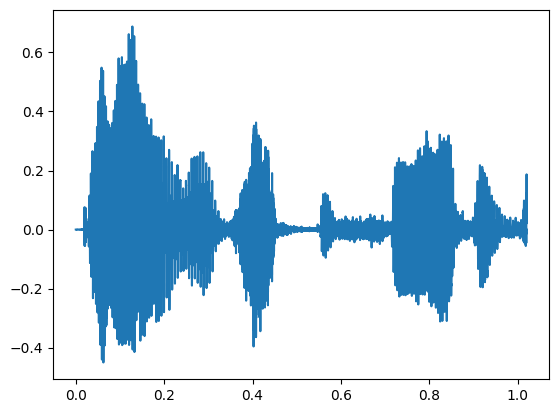

In [191]:
plt.plot(np.arange(len(wav[:22500])) / sr, wav[:22500])

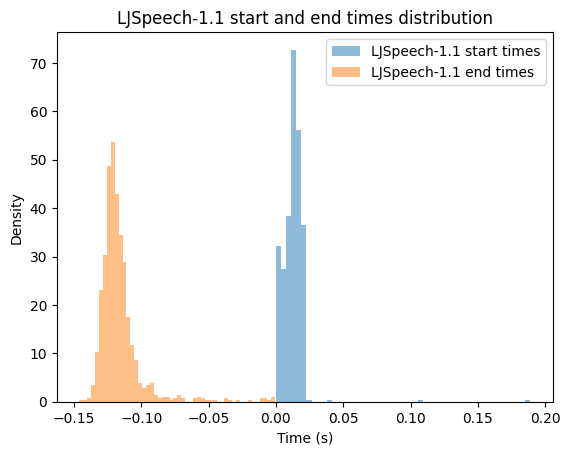

In [192]:
starts_s = []
ends_s = []

for i, e in enumerate(list(ljwavsdir.glob("*.wav"))[:1000]):
    wav, sr = sf.read(e)
    mask = wav > 0.01
    where_mask = np.where(mask)[0]
    start = where_mask[0]
    start_s = start / sr
    starts_s.append(start_s)
    end = where_mask[-1]
    end_s = end / sr
    ends_s.append(end_s - wav.shape[0] / sr)
plt.hist(starts_s, bins=50, alpha=0.5, density=True, label="LJSpeech-1.1 start times")
plt.hist(ends_s, bins=50, alpha=0.5, density=True, label="LJSpeech-1.1 end times")
plt.xlabel("Time (s)")
plt.ylabel("Density")
plt.title("LJSpeech-1.1 start and end times distribution")
plt.legend()
plt.show();